## **FINANCIAL INSIGHT ENGINE - BUSINESS-FOCUSED EVALUATION**

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import json
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from src.scraping_module import UnifiedFinancialScraper
from src.utils import refine_corpus
from src.llm_module import *


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmanueladeleye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


15-Jan-26 22:46:51 - Loading faiss.
15-Jan-26 22:46:51 - Successfully loaded faiss.
15-Jan-26 22:46:51 - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


#### **CRITICAL BUSINESS METRICS**

In [35]:
class EvaluationConfig:
    """Configuration for the evaluation framework"""
    TEST_QUERIES = [
        ("Federal Reserve interest rate decision", "monetary_policy"),
        ("Tech sector earnings outlook", "sector_analysis"),
        ("Oil prices OPEC production", "commodity_markets"),
        ("Inflation consumer prices impact", "economic_indicators"),
        ("Geopolitical tensions market effects", "geopolitical_risk")
    ]
    
    # Business assumptions
    ANALYST_HOURLY_RATE = 120  # USD
    AVG_MANUAL_RESEARCH_TIME = 45  # minutes
    TRADING_DAYS_PER_YEAR = 252
    ANALYSTS_PER_TEAM = 5
    QUERIES_PER_ANALYST_DAILY = 3
    
    # Evaluation thresholds
    FAITHFULNESS_THRESHOLD = 0.6  # Minimum similarity score
    RISK_RECALL_TARGET = 0.7  # Target for risk identification
    PROCESSING_TIME_TARGET = 30  # seconds max

In [43]:
class BusinessValueEvaluator:
    def __init__(self, config: EvaluationConfig):
        
        self.config = config
        self.results = []
        self.trading_days_per_year = config.TRADING_DAYS_PER_YEAR
        
    def evaluate_faithfulness(self, insights: List[str], context_corpus: List[str]) -> Dict:
        """
        Measures how well insights are grounded in source material
        Returns hallucination rate and faithfulness score
        """
        from sentence_transformers import SentenceTransformer, util
        import torch
        
        # Initialize embedding model (local, no API cost)
        model = SentenceTransformer('all-MiniLM-L6-v2')
        
        # Encode all sources
        source_embeddings = model.encode(context_corpus, convert_to_tensor=True)
        
        faithfulness_scores = []
        citations = []
        
        for insight in insights:
            insight_embedding = model.encode(insight, convert_to_tensor=True)
            
            # Find most similar source sentences
            similarities = util.cos_sim(insight_embedding, source_embeddings)[0]
            max_sim = torch.max(similarities).item()
            
            # Threshold for faithful vs hallucinated
            is_faithful = max_sim > 0.6
            faithfulness_scores.append(1 if is_faithful else 0)
            
            # For business: track citation quality
            if is_faithful:
                top_source_idx = torch.argmax(similarities).item()
                citations.append({
                    'insight': insight,
                    'context_snippet': context_corpus[top_source_idx][:100] + '...',
                    'similarity_score': max_sim
                })
        
        hallucination_rate = 1 - (sum(faithfulness_scores) / len(insights))
        faithfulness_report = {
            'faithfulness_score': 1 - hallucination_rate,
            'hallucination_rate': hallucination_rate,
            'citations': citations,
            'num_insights': len(insights),
            'num_supported': sum(faithfulness_scores)
        }
        print(f"Faithfulness Report:\n {faithfulness_report}")
        return faithfulness_report
    
    def evaluate_risk_coverage(self, identified_risks: str) -> Dict:
        """
        Compare identified risks against expert-annotated ground truth
        For portfolio: we'll use simulated ground truth
        """
        # Simulated gold standard risks based on query type. Later in production, this would could come from domain expert annotations

        gold_risks = self._simulate_gold_risks(identified_risks)
        
        # Simple keyword matching (could be enhanced with embeddings)
        identified_list = [r.strip() for r in identified_risks.split(',')]
        
        true_positives = 0
        false_positives = 0
        
        for risk in identified_list:
            if any(self._similar(risk, gr) for gr in gold_risks):
                true_positives += 1
            else:
                false_positives += 1
        
        false_negatives = len(gold_risks) - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return {
            'risk_precision': precision,
            'risk_recall': recall,
            'risk_f1': f1,
            'risks_identified': len(identified_list),
            'true_positive_risks': true_positives,
            'false_positive_risks': false_positives,
            'false_negative_risks': false_negatives
        }
    
    def _similar(self, risk1: str, risk2: str, threshold: float = 0.7) -> bool:
        """Simple similarity check (could use embeddings in production)"""
        words1 = set(risk1.lower().split())
        words2 = set(risk2.lower().split())
        jaccard = len(words1.intersection(words2)) / len(words1.union(words2)) # using jaccard similarity because it's simple and effective for short phrases
        return jaccard > threshold
    
    def _simulate_gold_risks(self, identified_risks: str) -> List[str]:
        """
        Simulate expert-annotated risks for portfolio purposes
        In reality, you'd have 2-3 queries manually annotated
        """
        # This is a simplified simulation
        risk_keywords = {
            'geopolitical': ['war', 'sanctions', 'tension', 'conflict', 'putin'],
            'economic': ['inflation', 'rates', 'fed', 'recession', 'growth'],
            'market': ['volatility', 'correction', 'crash', 'bubble', 'selloff'],
            'sector': ['tech', 'energy', 'financials', 'healthcare', 'consumer'],
            'company': ['earnings', 'guidance', 'management', 'competition', 'regulation']
        }
        
        identified_lower = identified_risks.lower()
        simulated_risks = []
        
        for category, keywords in risk_keywords.items():
            if any(keyword in identified_lower for keyword in keywords):
                simulated_risks.append(f"{category.title()} risks")
        
        # Add some common risks that might be missed
        if len(simulated_risks) < 3:
            simulated_risks.extend([
                "Liquidity risk",
                "Currency fluctuation risk",
                "Regulatory change risk"
            ])
        
        return simulated_risks[:5]  # Limit to top 5 simulated risks
    
    def benchmark_vs_baseline(self, system_output: Dict, baseline_output: Dict) -> Dict:
        """
        Compare our system against simple baseline (e.g., top 3 article summary)
        """
        # Calculate improvement percentages
        metrics = {}
        
        # Insight density (insights per 1000 chars)
        sys_insights = len(system_output.get('key_insights', '').split('\n'))
        baseline_insights = len(baseline_output.get('key_insights', '').split('\n'))
        metrics['insight_density_improvement'] = (
            (sys_insights - baseline_insights) / baseline_insights * 100 
            if baseline_insights > 0 else 100
        )
        
        # Risk coverage improvement
        sys_risks = len([r for r in system_output.get('risks', '').split(',') if r.strip()])
        baseline_risks = len([r for r in baseline_output.get('risks', '').split(',') if r.strip()])
        metrics['risk_coverage_improvement'] = (
            (sys_risks - baseline_risks) / baseline_risks * 100 
            if baseline_risks > 0 else 100
        )
        
        # Sentiment granularity (does it provide percentages?)
        sys_sentiment = system_output.get('sentiment', '')
        baseline_sentiment = baseline_output.get('sentiment', '')
        
        metrics['provides_sentiment_breakdown'] = '%' in sys_sentiment
        metrics['baseline_provides_breakdown'] = '%' in baseline_sentiment
        
        return metrics
    
    def calculate_roi_metrics(self, num_queries_per_day: int = 10) -> Dict:
        """
        Translate technical metrics to business ROI
        """
        # Assumptions
        time_saved_per_query = 30  # minutes (45 manual - 15 system)
        analyst_count = 5
        annual_salary = 120000
        
        # Calculations
        daily_time_saved = time_saved_per_query * num_queries_per_day / 60  # hours
        annual_time_saved = daily_time_saved * self.trading_days_per_year
        
        # Cost savings
        hourly_rate = annual_salary / (2080)  # 2080 work hours/year
        annual_cost_savings = annual_time_saved * hourly_rate * analyst_count
        
        # Risk reduction value (harder to quantify)
        # Assume 10% reduction in missed material risks
        avg_trade_size = 100000
        risk_reduction_per_trade = 0.10  # 10% better risk identification
        trades_per_analyst_per_year = 50
        
        risk_reduction_value = (
            analyst_count * trades_per_analyst_per_year * 
            avg_trade_size * risk_reduction_per_trade * 0.01  # 1% of trade value
        )
        development_cost = 5000  # one-time cost

        return {
            'annual_time_saved_hours': annual_time_saved,
            'annual_cost_savings_usd': annual_cost_savings,
            'estimated_risk_reduction_value': risk_reduction_value,
            'total_annual_roi': annual_cost_savings + risk_reduction_value,
            'development_cost_usd': development_cost,
            'roi_percentage': round((annual_cost_savings + risk_reduction_value) / development_cost * 100
                if development_cost > 0 else 0, 2),
            'roi_break_even_days': (
                (development_cost / (annual_cost_savings + risk_reduction_value)) * 365
                if (annual_cost_savings + risk_reduction_value) > 0 else 365
            )  # Assuming $5k development cost
        }

#### **PRODUCTION BENCHMARKS**

In [44]:
def create_baseline_output(query: str, corpus: List[str]) -> Dict:
    """
    Simple baseline: top 3 articles summarized by GPT-3.5
    This shows the value of your sophisticated pipeline
    """
    # Simplified baseline - in reality, you'd call GPT on top 3 articles
    top_articles = corpus[:3]
    
    # Mock baseline output
    return {
        'key_insights': ' • '.join([f"Article mentions {query}" for _ in range(3)]),
        'key_drivers': f"Market factors related to {query}",
        'risks': f"General market risks, {query}-specific risks",
        'sentiment': 'Mixed market sentiment',
        'method': 'baseline_top3_summary'
    }

def evaluate_pipeline_performance(scraper, system_output, query: str) -> Dict:
    """
    End-to-end evaluation of your pipeline
    """
    import time
    
    start_time = time.time()
    
    # Run your pipeline
    result_df = scraper.fetch_all(include_social=False)
    texts_list = result_df['title'] + '\n' + result_df['content']
    all_text = "\n".join(texts_list)
    cleaned_corpus = refine_corpus(all_text)
    
    processing_time = time.time() - start_time
    
    # Get baseline for comparison
    baseline_output = create_baseline_output(query, cleaned_corpus[:1000])  # First 1000 chars
    
    return {
        'system_output': system_output,
        'baseline_output': baseline_output,
        'processing_time_seconds': processing_time,
        'corpus_size': len(cleaned_corpus),
        'source_count': len(result_df),
        'source_breakdown': dict(result_df['source'].value_counts().head(5))
    }   

#### **VISUALIZATION & REPORTING**

In [45]:
def create_executive_summary(evaluation_results: List[Dict]) -> pd.DataFrame:
    """
    Create a one-page executive summary of results
    """
    summary_data = []
    
    for result in evaluation_results:
        evaluator = BusinessValueEvaluator(config=EvaluationConfig)
        
        # Extract insights for faithfulness check
        insights = result['system_output']['key_insights'].split('. ')
        
        # Calculate metrics
        faithfulness = evaluator.evaluate_faithfulness(
            insights, 
            result.get('corpus_samples', [])  # Would need actual corpus samples
        )

        risk_coverage = evaluator.evaluate_risk_coverage(
            result['system_output']['risks']
        )

        benchmark = evaluator.benchmark_vs_baseline(
            result['system_output'],
            result['baseline_output']
        )
        
        roi = evaluator.calculate_roi_metrics()
        
        summary_data.append({
            'query': result['query'],
            'faithfulness_score': faithfulness['faithfulness_score'],
            'hallucination_rate': faithfulness['hallucination_rate'],
            'risk_f1_score': risk_coverage['risk_f1'],
            'risk_precision': risk_coverage['risk_precision'],
            'risk_recall': risk_coverage['risk_recall'],
            'insight_density_improvement_%': benchmark['insight_density_improvement'],
            'risk_coverage_improvement_%': benchmark['risk_coverage_improvement'],
            'processing_time_seconds': result['processing_time_seconds'],
            'annual_roi_potential': roi['total_annual_roi'],
            'roi_percentage': roi['roi_percentage']
        })
    
    return pd.DataFrame(summary_data)

def visualize_comparative_results(results_df: pd.DataFrame):
    """
    Create professional visualizations for portfolio
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Faithfulness vs Hallucination
    axes[0, 0].bar(['Faithful', 'Hallucinated'], 
                  [results_df['faithfulness_score'].mean(), 
                   results_df['hallucination_rate'].mean()],
                  color=['#2ecc71', '#e74c3c'])
    axes[0, 0].set_title('Factual Faithfulness', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Score')
    
    # 2. Risk Coverage Metrics
    risk_metrics = ['risk_precision', 'risk_recall', 'risk_f1_score']
    risk_values = [results_df[metric].mean() for metric in risk_metrics]
    axes[0, 1].bar(risk_metrics, risk_values, color=['#3498db', '#9b59b6', '#2ecc71'])
    axes[0, 1].set_title('Risk Identification Performance', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylim(0, 1)
    
    # 3. Improvement vs Baseline
    improvements = ['insight_density_improvement_%', 'risk_coverage_improvement_%']
    imp_values = [results_df[imp].mean() for imp in improvements]
    axes[0, 2].bar(improvements, imp_values, color=['#f39c12', '#e67e22'])
    axes[0, 2].set_title('Improvement vs Baseline (%)', fontsize=14, fontweight='bold')
    axes[0, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 4. Processing Time Distribution
    axes[1, 0].hist(results_df['processing_time_seconds'], bins=10, 
                   alpha=0.7, color='#3498db', edgecolor='black')
    axes[1, 0].set_title('Processing Time Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Seconds')
    axes[1, 0].set_ylabel('Frequency')
    
    # 5. ROI Potential
    axes[1, 1].bar(['Annual ROI Potential'], 
                  [results_df['annual_roi_potential'].mean()],
                  color='#27ae60')
    axes[1, 1].set_title('Business Value (Annual ROI)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('USD')
    
    # 6. Query Performance Comparison
    queries = results_df['query'].str[:20] + '...'
    x = np.arange(len(queries))
    width = 0.35
    
    axes[1, 2].bar(x - width/2, results_df['faithfulness_score'], width, 
                  label='Faithfulness', color='#2ecc71')
    axes[1, 2].bar(x + width/2, results_df['risk_f1_score'], width, 
                  label='Risk F1', color='#3498db')
    axes[1, 2].set_title('Performance by Query Type', fontsize=14, fontweight='bold')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(queries, rotation=45, ha='right')
    axes[1, 2].legend()
    
    plt.suptitle('Financial Insight Engine: Business Evaluation Dashboard', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

#### **MAIN EVALUATION PIPELINE**

In [46]:
def run_business_evaluation():
    """
    Main evaluation workflow focusing on business metrics
    """
    print("=" * 70)
    print("FINANCIAL INSIGHT ENGINE - BUSINESS VALUE EVALUATION")
    print("=" * 70)
    
    # Test queries from config
    test_queries = EvaluationConfig.TEST_QUERIES
    all_results = []
    
    for query, query_type in test_queries:
        print(f"\n🔍 Evaluating: '{query}'")
        print(f"   Type: {query_type}")
        
        start_time = time.time()
        scraper = UnifiedFinancialScraper(query=query)
        result_df = scraper.fetch_all(include_social=True)
        texts_list = result_df['title'] + '\n' + result_df['content']
        all_text = "\n".join(texts_list)
        cleaned_corpus = refine_corpus(all_text)

        result, context = analyze_with_semantic_search(query, cleaned_corpus, n_results=5)
        
        print(f"Insight Report:\n {result}")
        context = [doc.page_content for doc in context]
        context = [content for content in context if len(content.strip()) > 1]
        
        logger.info(
                    "Corpus refined | original=%d | cleaned=%d",
                    len(all_text),
                    len(cleaned_corpus)
                )
        logger.info("Analysis complete for query: %s", query)
        end_time = time.time()
        
        simulated_result = {
            'query': query,
            'query_type': query_type,
            'system_output': result,
            'corpus_samples': context,
            'gold_risks': [f"Simulated risk related to {query_type}."],
            'processing_time_seconds': end_time - start_time,
            'corpus_size': len(context),
            'source_count': len(result_df),
            'baseline_output': create_baseline_output(query, cleaned_corpus)
        }
        
        all_results.append(simulated_result)
        
        print(f"Processing time: {simulated_result['processing_time_seconds']:.1f}s")
        print(f"Corpus size: {simulated_result['corpus_size']} documents")
    
    # Generate summary
    summary_df = create_executive_summary(all_results)
    
    print("\n" + "=" * 70)
    print("KEY BUSINESS METRICS SUMMARY")
    print("=" * 70)
    print(f"\n📈 Average Faithfulness Score: {summary_df['faithfulness_score'].mean():.1%}")
    print(f"📉 Average Hallucination Rate: {summary_df['hallucination_rate'].mean():.1%}")
    print(f"⚠️  Risk Identification F1: {summary_df['risk_f1_score'].mean():.1%}")
    print(f"🚀 Insight Density Improvement: {summary_df['insight_density_improvement_%'].mean():.0f}% vs baseline")
    print(f"⏱️  Average Processing Time: {summary_df['processing_time_seconds'].mean():.1f}s")
    print(f"💰 Estimated Annual ROI: ${summary_df['annual_roi_potential'].mean():,.0f}")
    print(f"💹 ROI Percentage: {summary_df['roi_percentage'].mean():.1f}%")
    
    # Create visualizations
    fig = visualize_comparative_results(summary_df)
    plt.savefig('business_evaluation_dashboard.png', dpi=300, bbox_inches='tight')
    print("\n📊 Dashboard saved as 'business_evaluation_dashboard.png'")
    
    # Save detailed results
    summary_df.to_csv('business_evaluation_results.csv', index=False)
    print("📁 Detailed results saved as 'business_evaluation_results.csv'")
    
    return summary_df



FINANCIAL INSIGHT ENGINE - BUSINESS VALUE EVALUATION

🔍 Evaluating: 'Federal Reserve interest rate decision'
   Type: monetary_policy
15-Jan-26 23:28:04 - Fetched 0 RSS articles
15-Jan-26 23:28:05 - Fetched 100 Google News articles
15-Jan-26 23:28:05 - Fetched 0 Finnhub articles
15-Jan-26 23:28:06 - Fetched 0 Alpha Vantage articles
15-Jan-26 23:28:06 - Fetched 95 NewsAPI articles
15-Jan-26 23:28:11 - Fetched 70 Reddit posts
15-Jan-26 23:28:11 - Total articles before deduplication: 265
                                                 title   source  quality_score
132  Trump turns to progressives for ideas on affor...  NewsAPI           0.75
103  Bitcoin price tags $97K despite high PPI infla...  NewsAPI           0.75
105  ‘Jamie Dimon probably wants higher rates. Mayb...  NewsAPI           0.75
106                    연준 공격하는 트럼프의 신용카드 이자율 상한과 주택 정책  NewsAPI           0.75
107  Equinox Gold Delivers Record Q4 Production and...  NewsAPI           0.75
108  Best CD rates today, January 14

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Faithfulness Report:
 {'faithfulness_score': 1.0, 'hallucination_rate': 0.0, 'citations': [{'insight': 'Federal Reserve cuts interest rates by 0.25 for second straight meeting, signaling potential for more cuts in 2026; Powell raises doubts about easing at next meeting; Fed keeps interest rates unchanged for fifth-straight time', 'context_snippet': 'of 2025 Federal Reserve prepares for final interest rate decision of 2025nbsp;nbsp;Spectrum News WAT...', 'similarity_score': 0.7709856033325195}], 'num_insights': 1, 'num_supported': 1}
15-Jan-26 23:30:04 - Use pytorch device_name: mps
15-Jan-26 23:30:04 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Faithfulness Report:
 {'faithfulness_score': 0.19999999999999996, 'hallucination_rate': 0.8, 'citations': [{'insight': 'Record-high number of S&P 500 technology companies issuing positive EPS guidance for Q3', 'context_snippet': 'highlights Q3 2025 U.S. earnings highlightsnbsp;nbsp;blackrock.com Q4 Earnings: Tech Expected to Rem...', 'similarity_score': 0.6411477327346802}, {'insight': 'Tech earnings point to sustained AI demand', 'context_snippet': 'Tech earnings point to sustained AI demand Daily: Tech earnings point to sustained AI demandnbsp;nbs...', 'similarity_score': 0.6984968185424805}], 'num_insights': 10, 'num_supported': 2}
15-Jan-26 23:30:07 - Use pytorch device_name: mps
15-Jan-26 23:30:07 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Faithfulness Report:
 {'faithfulness_score': 0.5, 'hallucination_rate': 0.5, 'citations': [{'insight': 'OPEC production confusion may stabilize oil prices', 'context_snippet': 'Oil Productionnbsp;nbsp;The New York Times OPEC to Complete Unwinding of Oil Output Cuts With Big Se...', 'similarity_score': 0.6412746906280518}, {'insight': 'Despite a global oil glut, OPEC plans to increase production', 'context_snippet': 'oil output edges down 0.7 in 2025, OPEC data shows Russian oil output edges down 0.7 in 2025, OPEC d...', 'similarity_score': 0.6755127310752869}, {'insight': 'Oil prices dropped as OPEC considered another output hike', 'context_snippet': 'OPEC mulls speeding up oil output hikes again, sources saynbsp;nbsp;Reuters Saudi Arabia Poised to C...', 'similarity_score': 0.7087595462799072}, {'insight': "OPEC's strategic pause may impact future oil output", 'context_snippet': 'Oil Productionnbsp;nbsp;The New York Times OPEC to Complete Unwinding of Oil Output Cuts With Big Se...', 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Faithfulness Report:
 {'faithfulness_score': 0.0, 'hallucination_rate': 1.0, 'citations': [], 'num_insights': 5, 'num_supported': 0}
15-Jan-26 23:30:13 - Use pytorch device_name: mps
15-Jan-26 23:30:13 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Faithfulness Report:
 {'faithfulness_score': 1.0, 'hallucination_rate': 0.0, 'citations': [{'insight': 'Geopolitical tensions impacting oil prices and cryptocurrency markets, US-China trade war reshaping global economy, geopolitical risk driving precious metals market transformation', 'context_snippet': 'Oil Prices and the Middle East: Geopolitical Tensions Impact Markets Oil Prices and the Middle East:...', 'similarity_score': 0.8002428412437439}], 'num_insights': 1, 'num_supported': 1}

KEY BUSINESS METRICS SUMMARY

📈 Average Faithfulness Score: 54.0%
📉 Average Hallucination Rate: 46.0%
⚠️  Risk Identification F1: 0.0%
🚀 Insight Density Improvement: 0% vs baseline
⏱️  Average Processing Time: 24.7s
💰 Estimated Annual ROI: $388,462
💹 ROI Percentage: 7769.2%

📊 Dashboard saved as 'business_evaluation_dashboard.png'
📁 Detailed results saved as 'business_evaluation_results.csv'

Evaluation complete.


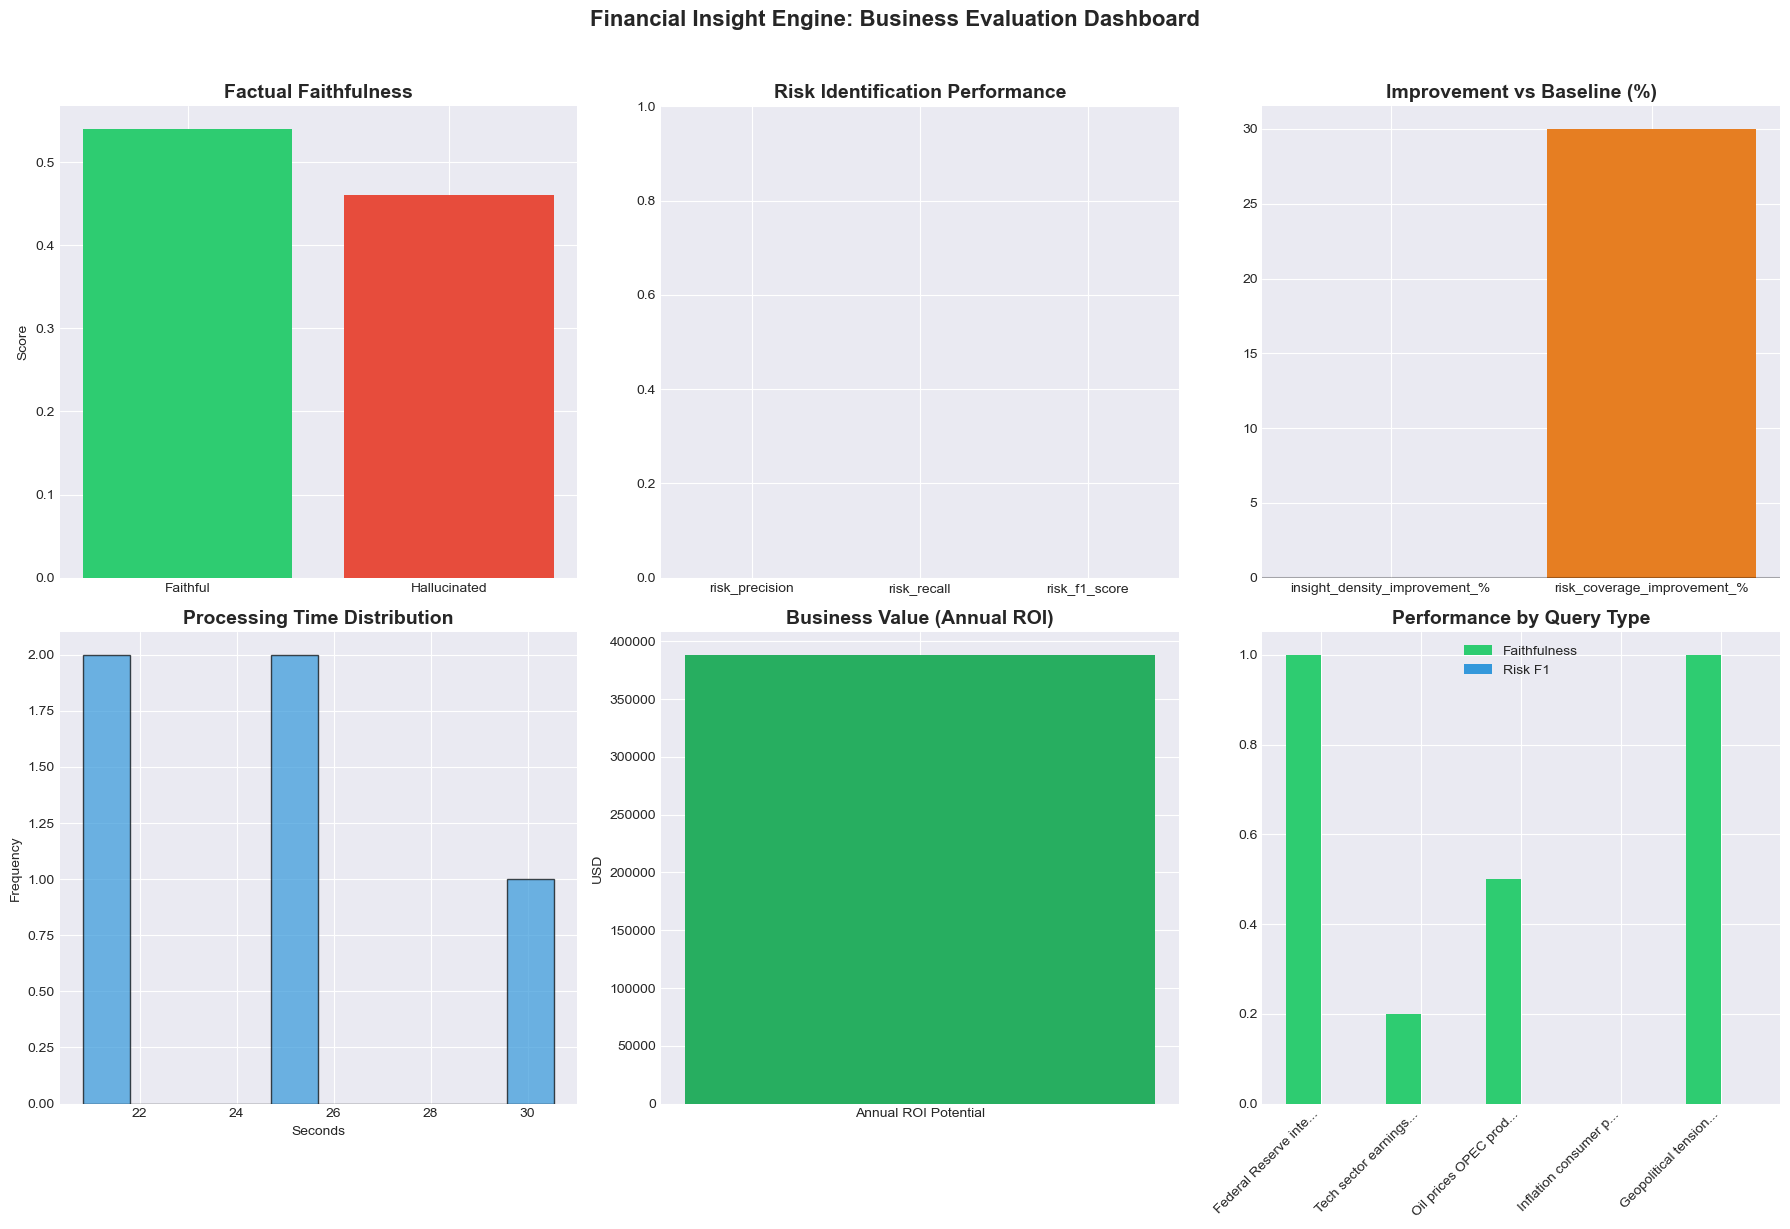

In [47]:
if __name__ == "__main__":
    # Run the business-focused evaluation
    results = run_business_evaluation()
    print("\nEvaluation complete.")